## **(-)Mounting Resource**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 5.6 MB/s eta 0:00:00


## **(o) Requirements, and Prepare**

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import cv2
import shutil
import random
import re

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

**Gathering Data**

In [4]:
# Path ke folder dataset
dataset_path = '/content/drive/MyDrive/UAP_MACHINE LEARNING/Dataset'

# Mendapatkan daftar folder dalam dataset
classes = os.listdir(dataset_path)

In [5]:
class_counts = {}
sample_images = {}
sample_edges = {}

In [6]:
count_various_classes = len(classes)

## **(i) EDA**

Distribusi Class & Data

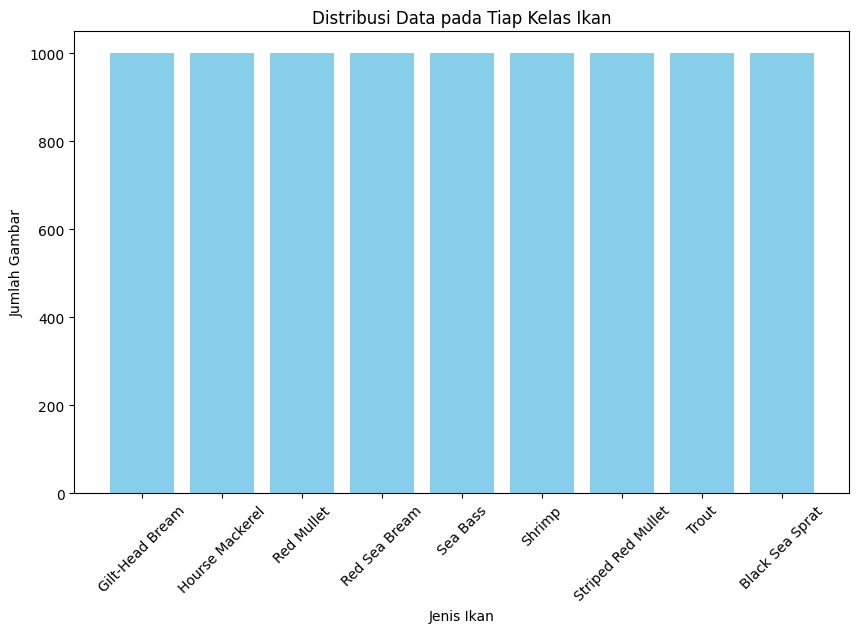

In [7]:
for weapon_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, weapon_class)

    if os.path.isdir(class_path):  # Pastikan path tersebut adalah folder
        images = os.listdir(class_path)
        class_counts[weapon_class] = len(images)  # Hitung jumlah gambar per kelas

        # Ambil satu contoh gambar dari tiap kelas
        if images:
            sample_images[weapon_class] = os.path.join(class_path, images[0])

# Menampilkan distribusi data
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Distribusi Data pada Tiap Kelas Ikan")
plt.xlabel("Jenis Ikan")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

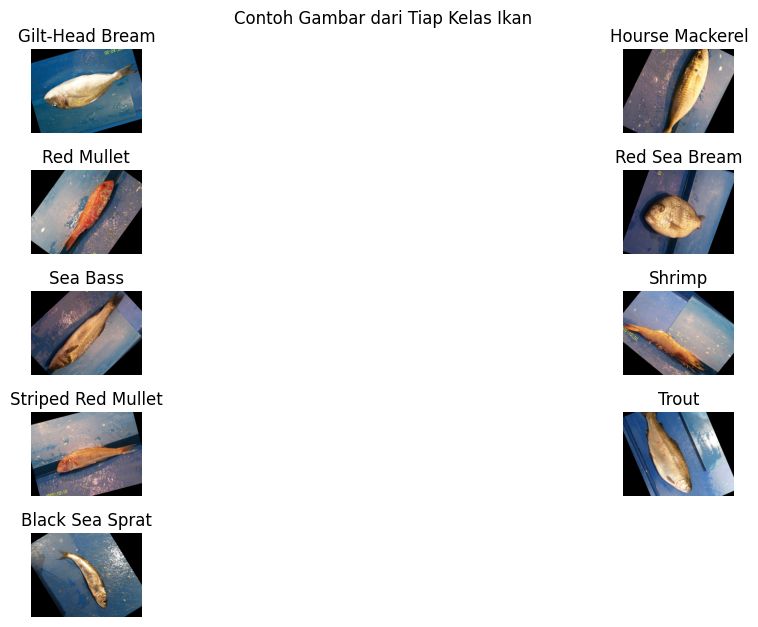

In [8]:
plt.figure(figsize=(12, 15))
for i, (weapon_class, image_path) in enumerate(sample_images.items(), 1):
    img = Image.open(image_path)
    plt.subplot(12, 2, i)  # Menyesuaikan jumlah subplot dengan kelas yang ada (2 baris, 3 kolom)
    plt.imshow(img)
    plt.title(weapon_class)
    plt.axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas Ikan")
plt.tight_layout()
plt.show()

## **(ii) Splitting Dataset**

In [9]:
import os
import random
import shutil

def split_dataset(dataset_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Memisahkan dataset menjadi train, validation, dan test berdasarkan rasio yang ditentukan,
    serta menambahkan prefix nama kelas pada setiap file gambar.

    Parameters:
        dataset_path (str): Path ke folder dataset asli.
        output_path (str): Path ke folder output untuk menyimpan dataset yang sudah dipisah.
        train_ratio (float): Proporsi data untuk train set.
        val_ratio (float): Proporsi data untuk validation set.
        test_ratio (float): Proporsi data untuk test set.
    """
    # Membuat folder output jika belum ada
    os.makedirs(output_path, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    # Mendapatkan daftar kelas (subfolder di dalam dataset)
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            # Mendapatkan daftar file gambar dan mengacak urutannya
            images = os.listdir(class_path)
            random.shuffle(images)

            # Menghitung jumlah gambar untuk setiap split
            total_images = len(images)
            train_count = int(total_images * train_ratio)
            val_count = int(total_images * val_ratio)

            # Menghitung indeks pemisahan gambar
            train_images = images[:train_count]
            val_images = images[train_count:train_count + val_count]
            test_images = images[train_count + val_count:]

            # Membuat folder kelas di dalam folder split dan menyalin file gambar
            for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
                split_class_path = os.path.join(output_path, split, class_name)
                os.makedirs(split_class_path, exist_ok=True)

                # Menyalin file gambar ke folder split yang sesuai dan mengganti nama file
                for i, image_name in enumerate(split_images, start=1):
                    src_image_path = os.path.join(class_path, image_name)
                    dst_image_name = f"{class_name}_{i}.jpg"
                    dst_image_path = os.path.join(split_class_path, dst_image_name)
                    shutil.copy(src_image_path, dst_image_path)


In [10]:
# Path untuk menyimpan dataset yang sudah dipisah
output_path = 'Dataset_split/'

# Menjalankan fungsi untuk memisahkan dataset
split_dataset(dataset_path, output_path)

## **(iii) Preprocessing**

Functions Preparing

In [11]:
def resize_images(input_path, output_path, size=(224, 224)):
    """
    Meresize setiap gambar dalam input_path ke ukuran yang ditentukan
    dan menyimpannya di output_path.

    Parameters:
        input_path (str): Path ke folder input (misalnya Dataset_split).
        output_path (str): Path ke folder output untuk menyimpan gambar yang sudah diresize.
        size (tuple): Ukuran yang diinginkan untuk setiap gambar (lebar, tinggi).
    """
    # Membuat folder output jika belum ada
    os.makedirs(output_path, exist_ok=True)

    # Mendapatkan daftar folder split (train, val, test)
    splits = os.listdir(input_path)

    for split in splits:
        split_path = os.path.join(input_path, split)
        if os.path.isdir(split_path):
            # Membuat subfolder split di output path
            split_output_path = os.path.join(output_path, split)
            os.makedirs(split_output_path, exist_ok=True)

            # Mendapatkan daftar kelas dalam split
            classes = os.listdir(split_path)

            for class_name in classes:
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    # Membuat subfolder kelas di output path
                    class_output_path = os.path.join(split_output_path, class_name)
                    os.makedirs(class_output_path, exist_ok=True)

                    # Mendapatkan daftar gambar di dalam kelas
                    images = os.listdir(class_path)

                    for image_name in images:
                        # Path gambar asli
                        image_path = os.path.join(class_path, image_name)

                        # Membuka dan meresize gambar
                        with Image.open(image_path) as img:
                            # Mengonversi ke RGB jika gambar tidak dalam mode RGB
                            if img.mode != 'RGB':
                                img = img.convert('RGB')
                            resized_img = img.resize(size, Image.LANCZOS)

                            # Path untuk menyimpan gambar yang sudah diresize
                            output_image_path = os.path.join(class_output_path, image_name)

                            # Menyimpan gambar yang sudah diresize
                            resized_img.save(output_image_path)

In [12]:
# Path input ke folder dataset yang sudah dipisah (Dataset_split)
input_path = 'Dataset_split/'

# Path output untuk menyimpan gambar yang diresize
output_path = 'Dataset_R/'

# Menjalankan fungsi untuk meresize gambar
resize_images(input_path, output_path)

### **() Augmentation**

In [13]:
def augment_rotation(image, num_images=2):
    """Menghasilkan gambar yang dirotasi dengan sudut acak antara 0 hingga 20 derajat."""
    rotated_images = []
    for _ in range(num_images):
        angle = random.uniform(-20, 20)  # Sudut rotasi acak antara -20 dan 20
        rotated_img = image.rotate(angle)
        rotated_images.append(rotated_img)
    return rotated_images

In [14]:
def augment_flip(image):
    """Menghasilkan gambar yang di-flip horizontal dan vertikal."""
    flipped_images = []
    flipped_horizontal = image.transpose(Image.FLIP_LEFT_RIGHT)
    flipped_vertical = image.transpose(Image.FLIP_TOP_BOTTOM)
    flipped_images.extend([flipped_horizontal, flipped_vertical])
    return flipped_images

In [15]:
def augment_zoom(image, zoom_factor=1.2):
    """Menghasilkan gambar dengan zoom yang diberikan."""
    width, height = image.size
    new_size = (int(width * zoom_factor), int(height * zoom_factor))
    zoomed_img = image.resize(new_size, Image.LANCZOS)

    # Crop to original size
    left = (new_size[0] - width) // 2
    top = (new_size[1] - height) // 2
    right = left + width
    bottom = top + height
    cropped_zoomed_img = zoomed_img.crop((left, top, right, bottom))

    return cropped_zoomed_img

In [17]:
def augment_translate(image, max_translate=10):
    """Menghasilkan gambar dengan translasi (pergeseran) secara horizontal dan vertikal."""
    width, height = image.size
    x_translate = random.randint(-max_translate, max_translate)
    y_translate = random.randint(-max_translate, max_translate)

    translated_img = Image.new("RGB", (width, height), (0, 0, 0))
    translated_img.paste(image, (x_translate, y_translate))
    return translated_img

In [18]:
def augment_brightness(image, factor_range=(0.7, 1.3)):
    """Menghasilkan gambar dengan variasi pencahayaan (brightness)."""
    factor = random.uniform(*factor_range)  # Faktor pencahayaan acak
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

In [19]:
def augment_contrast(image, factor_range=(0.7, 1.3)):
    """Menghasilkan gambar dengan variasi kontras (contrast)."""
    factor = random.uniform(*factor_range)  # Faktor kontras acak
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)


In [20]:
def augment_dataset(input_path, output_path):
    """
    Melakukan augmentasi pada gambar di folder train dan menyimpannya di output_path.
    Menyalin folder val dan test tanpa augmentasi.

    Parameters:
        input_path (str): Path ke folder dataset yang sudah diresize (Dataset_R).
        output_path (str): Path ke folder untuk menyimpan gambar yang telah diaugmentasi (Dataset_R_A).
    """
    # Membuat folder output jika belum ada
    os.makedirs(output_path, exist_ok=True)

    # Mendapatkan daftar folder split (train, val, test)
    splits = os.listdir(input_path)

    for split in splits:
        split_path = os.path.join(input_path, split)
        if os.path.isdir(split_path):
            # Mendapatkan daftar kelas dalam split
            classes = os.listdir(split_path)

            # Buat folder split di output_path
            split_output_path = os.path.join(output_path, split)
            os.makedirs(split_output_path, exist_ok=True)

            for class_name in classes:
                class_path = os.path.join(split_path, class_name)
                class_output_path = os.path.join(split_output_path, class_name)

                if split == "train":
                    # Melakukan augmentasi hanya untuk folder train
                    os.makedirs(class_output_path, exist_ok=True)
                    images = os.listdir(class_path)

                    for image_name in images:
                        image_path = os.path.join(class_path, image_name)

                        with Image.open(image_path) as img:
                            # Augmentasi gambar
                            rotated_imgs = augment_rotation(img)
                            flipped_imgs = augment_flip(img)
                            zoomed_img = augment_zoom(img)
                            translated_img = augment_translate(img)
                            brightness_img = augment_brightness(img)
                            contrast_img = augment_contrast(img)

                            # Simpan gambar asli dan hasil augmentasi
                            img.save(os.path.join(class_output_path, f"original_{image_name}"))
                            # for i, rotated_img in enumerate(rotated_imgs):
                            #     rotated_img.save(os.path.join(class_output_path, f"rotated_{i}_{image_name}"))
                            # for i, flipped_img in enumerate(flipped_imgs):
                            #     flipped_img.save(os.path.join(class_output_path, f"flipped_{i}_{image_name}"))
                            zoomed_img.save(os.path.join(class_output_path, f"zoomed_{image_name}"))
                            translated_img.save(os.path.join(class_output_path, f"translated_{image_name}"))
                            brightness_img.save(os.path.join(class_output_path, f"brightness_{image_name}"))
                            contrast_img.save(os.path.join(class_output_path, f"contrast_{image_name}"))
                else:
                    # Untuk folder val dan test, hanya salin gambar tanpa augmentasi
                    os.makedirs(class_output_path, exist_ok=True)
                    images = os.listdir(class_path)

                    for image_name in images:
                        src_image_path = os.path.join(class_path, image_name)
                        dst_image_path = os.path.join(class_output_path, image_name)
                        shutil.copy2(src_image_path, dst_image_path)

In [21]:
# Path input ke folder dataset yang sudah diresize (Dataset_R)
input_path = 'Dataset_R/'

# Path output untuk menyimpan gambar yang diaugmentasi
output_path = 'Dataset_R_A/'

# Menjalankan fungsi untuk augmentasi dataset
augment_dataset(input_path, output_path)

## **(iv) Machine Leanring Requirements, Prepare**

In [22]:
def show_plot(history, output_dir):
    # Plotting hasil pelatihan
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1.2])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.savefig(os.path.join(output_dir, "Plot_visualization.png"))
    plt.show()
    plt.close()

In [23]:
def process_and_save_images_with_labels(type_generator, model, output_dir):
    """
    Save images with predicted and actual labels, and separate misclassified images.
    """
    class_indices_rev = {v: k for k, v in type_generator.class_indices.items()}

    # Buat direktori output
    image_label_dir = os.path.join(output_dir, "image_label")
    image_label_wrong_dir = os.path.join(output_dir, "image_label_wrong_predict")
    os.makedirs(image_label_dir, exist_ok=True)
    os.makedirs(image_label_wrong_dir, exist_ok=True)

    # Loop melalui data type_generator
    for i in range(len(type_generator)):
        x_batch, y_true_batch = type_generator[i]
        y_pred_batch = model.predict(x_batch)
        y_pred_classes = y_pred_batch.argmax(axis=1)
        y_true_classes = y_true_batch.argmax(axis=1)

        for j in range(len(x_batch)):
            img = (x_batch[j] * 255).astype('uint8')  # Denormalisasi gambar
            true_label = class_indices_rev[y_true_classes[j]]
            pred_label = class_indices_rev[y_pred_classes[j]]

            # Konversi ke RGB (format matplotlib)
            img_rgb = img  # Tidak perlu konversi karena gambar sudah dalam format RGB

            # Buat plot
            plt.figure(figsize=(8, 8))
            plt.imshow(img_rgb)
            title_text = f"{i * type_generator.batch_size + j}\nPredicted: {pred_label}\nActual: {true_label}"
            plt.title(title_text, fontsize=14)
            plt.axis('off')  # Hilangkan sumbu

            # Simpan gambar ke folder berdasarkan kategori
            save_dir = os.path.join(image_label_dir, true_label)
            os.makedirs(save_dir, exist_ok=True)
            img_name = f"img_{i * type_generator.batch_size + j}.png"
            save_path = os.path.join(save_dir, img_name)
            plt.savefig(save_path, bbox_inches='tight')

            # Jika salah prediksi, simpan juga ke folder misclassification
            if true_label != pred_label:
                wrong_dir = os.path.join(image_label_wrong_dir, true_label, pred_label)
                os.makedirs(wrong_dir, exist_ok=True)
                wrong_save_path = os.path.join(wrong_dir, img_name)
                plt.savefig(wrong_save_path, bbox_inches='tight')
            plt.close()

In [24]:
def generate_analysis_report(model, type_generator, output_dir):
    import pandas as pd
    import os
    from sklearn.metrics import confusion_matrix

    # Balikkan indeks kelas untuk mendapatkan nama kelas dari indeks
    class_indices_rev = {v: k for k, v in type_generator.class_indices.items()}

    y_true = type_generator.classes
    y_pred = model.predict(type_generator).argmax(axis=1)

    labels = list(type_generator.class_indices.keys())
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    report_data = []
    misclassified_images = {label: {} for label in labels}

    # Kumpulkan data gambar yang salah diklasifikasikan
    for true_label, pred_label, idx in zip(y_true, y_pred, range(len(y_true))):
        if true_label != pred_label:
            true_label_name = labels[true_label]
            pred_label_name = labels[pred_label]
            if pred_label_name not in misclassified_images[true_label_name]:
                misclassified_images[true_label_name][pred_label_name] = []
            misclassified_images[true_label_name][pred_label_name].append(f"img_{idx + 1}.jpg")

    # Total gambar per kategori
    total_samples_per_class = {label: sum(1 for y in y_true if labels[y] == label) for label in labels}

    # Buat laporan berdasarkan data
    for true_label_name, misclassified_data in misclassified_images.items():
        total_samples = total_samples_per_class[true_label_name]

        first_misclassified_label = True
        for misclassified_label, image_names in misclassified_data.items():
            total_errors = len(image_names)
            error_percent = (total_errors / total_samples) * 100 if total_samples > 0 else 0
            formatted_error_percent = f"{error_percent:.2f}%" if first_misclassified_label else ""

            first_image = True
            for img_name in image_names:
                report_data.append({
                    "Kategori": true_label_name if first_misclassified_label else "",
                    "Frekuensi": formatted_error_percent if first_misclassified_label else "",
                    "Keterangan": misclassified_label if first_image else "",
                    "Kesalahan": total_errors if first_image else "",
                    "Image Name": img_name
                })
                first_misclassified_label = False
                first_image = False

    # Simpan laporan ke file Excel
    df = pd.DataFrame(report_data, columns=["Kategori", "Frekuensi", "Keterangan", "Kesalahan", "Image Name"])
    output_file = os.path.join(output_dir, "analysis_error.xlsx")

    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        df.to_excel(writer, index=False)
        worksheet = writer.sheets['Sheet1']
        worksheet.set_column('A:E', 20)  # Atur lebar kolom


In [25]:
def evaluate(model, type_generator, output_dir):
    # Mendapatkan label dan kelas
    y_true = type_generator.labels  # Menggunakan .labels alih-alih .classes
    y_pred = model.predict(type_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Urutkan kelas sesuai indeks
    classes = [k for k, v in sorted(type_generator.class_indices.items(), key=lambda item: item[1])]

    # Classification report
    report = classification_report(y_true, y_pred_classes, target_names=classes)
    print("Classification Report:")
    print(report)
    report_path = os.path.join(output_dir, "classification_report.txt")
    with open(report_path, "w") as file:
        file.write(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    fig_size = max(8, len(classes) // 2)  # Penyesuaian ukuran gambar
    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Menampilkan angka dalam confusion matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            color = "white" if cm[i, j] > cm.max() / 2. else "black"
            if cm[i, j] == 0:
                color = "grey"
            plt.text(j, i, cm[i, j], ha="center", color=color)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "Confusion_Matrix.png"))
    plt.show()
    plt.close()


In [36]:
import json

def train_cnn_model(model, train_data_path, val_data_path, test_data_path, epochs, batch_size, output_dir):
    # Data augmentation dan preprocessing
    datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = datagen.flow_from_directory(
        train_data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        val_data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Training model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )

    output_dir_eval = os.path.join(output_dir, "Evaluation")
    os.makedirs(output_dir_eval, exist_ok=True)

    # Plotting training history
    show_plot(history, output_dir_eval)

    print("\n\n Evaluate using validation data")
    # Evaluate on validation data
    output_val = os.path.join(output_dir_eval, "Validation")
    os.makedirs(output_val, exist_ok=True)
    evaluate(model, validation_generator, output_val)
    # process_and_save_images_with_labels(validation_generator, model, output_val)
    # generate_analysis_report(model, validation_generator, output_val)

    print("\n\n Evaluate using test data")
    # Evaluate on test data
    output_test = os.path.join(output_dir_eval, "Test")
    os.makedirs(output_test, exist_ok=True)
    evaluate(model, test_generator, output_test)
    # process_and_save_images_with_labels(test_generator, model, output_test)
    # generate_analysis_report(model, test_generator, output_test)

    # Save model
    model.save(os.path.join(output_dir, "model.h5"))
    print(f"Model saved to {output_dir}/model.h5")

    # Save model layers information
    model_layers_info = []
    for layer in model.layers:
        layer_info = {
            "name": layer.name,
            "class_name": layer.__class__.__name__,
            "num_params": layer.count_params()
        }
        # Handle optional attributes
        if hasattr(layer, 'input_shape'):
            layer_info["input_shape"] = layer.input_shape
        if hasattr(layer, 'output_shape'):
            layer_info["output_shape"] = layer.output_shape

        model_layers_info.append(layer_info)

    layers_info_path = os.path.join(output_dir, "model_layers.json")
    with open(layers_info_path, 'w') as f:
        json.dump(model_layers_info, f, indent=4)

    print(f"Model layers information saved to {layers_info_path}")

    # Save model summary
    summary_path = os.path.join(output_dir, "model_summary.txt")
    with open(summary_path, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))

    print(f"Model summary saved to {summary_path}")

    # # Save model summary as image
    # from tensorflow.keras.utils import plot_model
    # summary_image_path = os.path.join(output_dir, "model_summary.png")
    # plot_model(model, to_file=summary_image_path, show_shapes=True, show_layer_names=True)
    # print(f"Model summary image saved to {summary_image_path}")


In [27]:
output_root = "Result/Model"
os.makedirs(output_root, exist_ok=True)

## Skenario Model

In [31]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

# Load InceptionV3 pre-trained model
base_model = InceptionV3(
    weights='imagenet',  # Pre-trained weights on ImageNet
    include_top=False,   # Tidak menyertakan fully connected layer bawaan
    input_shape=(224, 224, 3)
)

# Tambahkan lapisan kustom setelah InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = BatchNormalization()(x)      # Batch Normalization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout untuk mencegah overfitting
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout
outputs = Dense(count_various_classes, activation='softmax')(x)  # Output layer

# Gabungkan base model dengan lapisan kustom
model_InceptionV3 = Model(inputs=base_model.input, outputs=outputs)

# Freeze semua lapisan pada base model untuk transfer learning awal
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model_InceptionV3.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer Adam dengan learning rate kecil
    loss='categorical_crossentropy',     # Loss untuk klasifikasi multi-kelas
    metrics=['accuracy']
)

Found 6300 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Epoch 1/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - accuracy: 0.3572 - loss: 2.1708 - val_accuracy: 0.9050 - val_loss: 0.3189
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.6090 - loss: 1.1706 - val_accuracy: 0.9050 - val_loss: 0.3044
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 68s 22ms/step - accuracy: 0.6980 - loss: 0.9443 - val_accuracy: 0.9544 - val_loss: 0.1799
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 62s 20ms/step - accuracy: 0.7503 - loss: 0.8223 - val_accuracy: 0.9544 - val_loss: 0.1531
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.7765 - loss: 0.7371 - val_accuracy: 0.9700 - val_loss: 0.1249
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 81s 19ms/step - accuracy: 0.7943 - loss: 0.6463 - val_accuracy: 0.9717 - val_loss: 0.1145
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 84s 20ms/step - accuracy: 0.8092 - loss: 

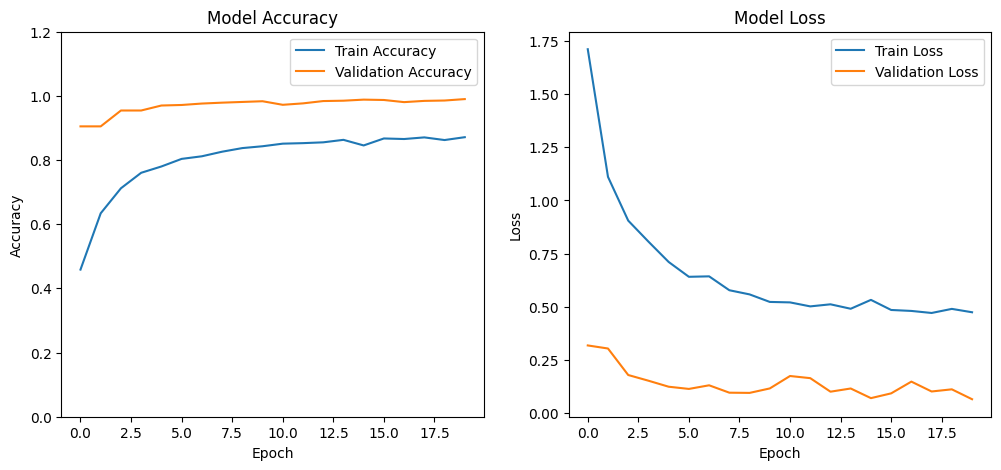



 Evaluate using validation data
900/900 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step
Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      0.99       200
   Gilt-Head Bream       0.98      0.99      0.99       200
   Hourse Mackerel       0.99      0.99      0.99       200
        Red Mullet       0.99      0.98      0.99       200
     Red Sea Bream       1.00      1.00      1.00       200
          Sea Bass       1.00      0.97      0.99       200
            Shrimp       1.00      1.00      1.00       200
Striped Red Mullet       0.97      0.96      0.97       200
             Trout       1.00      1.00      1.00       200

          accuracy                           0.99      1800
         macro avg       0.99      0.99      0.99      1800
      weighted avg       0.99      0.99      0.99      1800



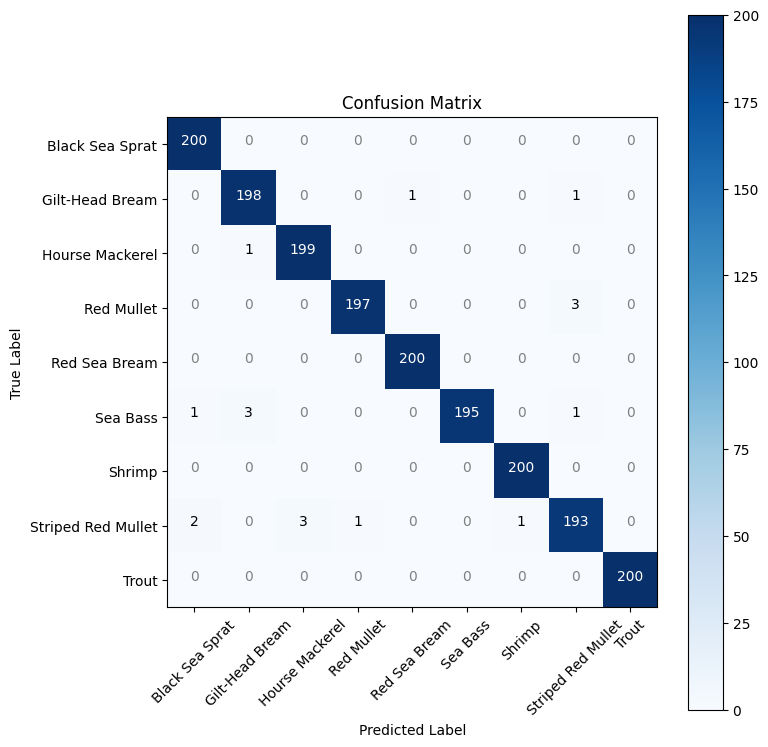

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       100
   Gilt-Head Bream       0.98      0.99      0.99       100
   Hourse Mackerel       0.97      1.00      0.99       100
        Red Mullet       0.97      1.00      0.99       100
     Red Sea Bream       0.99      1.00      1.00       100
          Sea Bass       1.00      0.98      0.99       100
            Shrimp       1.00      1.00      1.00       100
Striped Red Mullet       1.00      0.94      0.97       100
             Trout       1.00      1.00      1.00       100

          accuracy                           0.99       900
         macro avg       0.99      0.99      0.99       900
      weighted avg       0.99      0.99      0.99       900



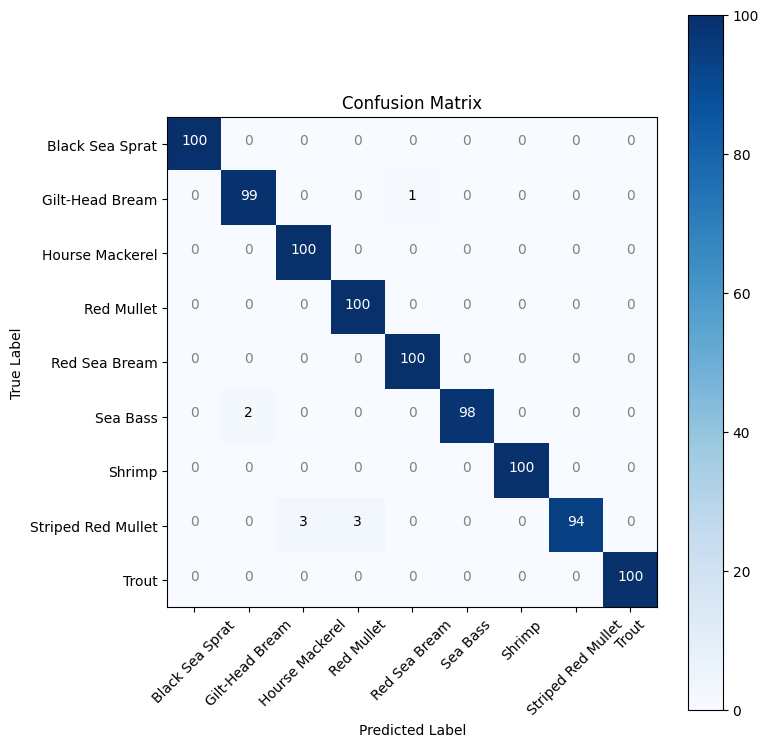

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

Model saved to Result/Model/Model_InceptionV3/model.h5
Model layers information saved to Result/Model/Model_InceptionV3/model_layers.json


Model summary saved to Result/Model/Model_InceptionV3/model_summary.txt


In [32]:
# Direktori untuk model
output_dir_model_InceptionV3 = os.path.join(output_root, "Model_InceptionV3")
os.makedirs(output_dir_model_InceptionV3, exist_ok=True)

# Melatih model
train_cnn_model(
    model_InceptionV3,
    os.path.join("Dataset_R", "train"),
    os.path.join("Dataset_R", "val"),
    os.path.join("Dataset_R", "test"),
    epochs=20,
    batch_size=2,
    output_dir=output_dir_model_InceptionV3
)

In [35]:
shutil.copytree(f"/content/{output_dir_model_InceptionV3}", f"/content/drive/MyDrive/UAP_MACHINE LEARNING/Result/Model/{output_dir_model_InceptionV3}", dirs_exist_ok=True)


'/content/drive/MyDrive/UAP_MACHINE LEARNING/Result/Model/Result/Model/Model_InceptionV3'

In [37]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(
    weights='imagenet',  # Pre-trained weights on ImageNet
    include_top=False,   # Tidak menyertakan fully connected layer bawaan
    input_shape=(224, 224, 3)
)

# Tambahkan lapisan kustom setelah MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = BatchNormalization()(x)      # Batch Normalization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout untuk mencegah overfitting
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout
outputs = Dense(count_various_classes, activation='softmax')(x)  # Output layer

# Gabungkan base model dengan lapisan kustom
model_MobileNetV2 = Model(inputs=base_model.input, outputs=outputs)

# Freeze semua lapisan pada base model untuk transfer learning awal
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model_MobileNetV2.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer Adam dengan learning rate kecil
    loss='categorical_crossentropy',     # Loss untuk klasifikasi multi-kelas
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 6300 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3150/3150 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - accuracy: 0.3892 - loss: 1.9350 - val_accuracy: 0.9667 - val_loss: 0.1062
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.7133 - loss: 0.9231 - val_accuracy: 0.9794 - val_loss: 0.0633
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.7736 - loss: 0.7223 - val_accuracy: 0.9844 - val_loss: 0.0625
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8180 - loss: 0.6114 - val_accuracy: 0.9889 - val_loss: 0.0460
Epoch 5/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.8226 - loss: 0.5626 - val_accuracy: 0.9828 - val_loss: 0.0848
Epoch 6/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8304 - loss: 0.5664 - val_accuracy: 0.9861 - val_loss: 0.0766
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 45s 13ms/step - accuracy: 0.8363 - loss: 0.5345 - val_accuracy: 0.9839 - val_loss: 0.1017
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - accuracy: 0.8552 - loss: 0.48

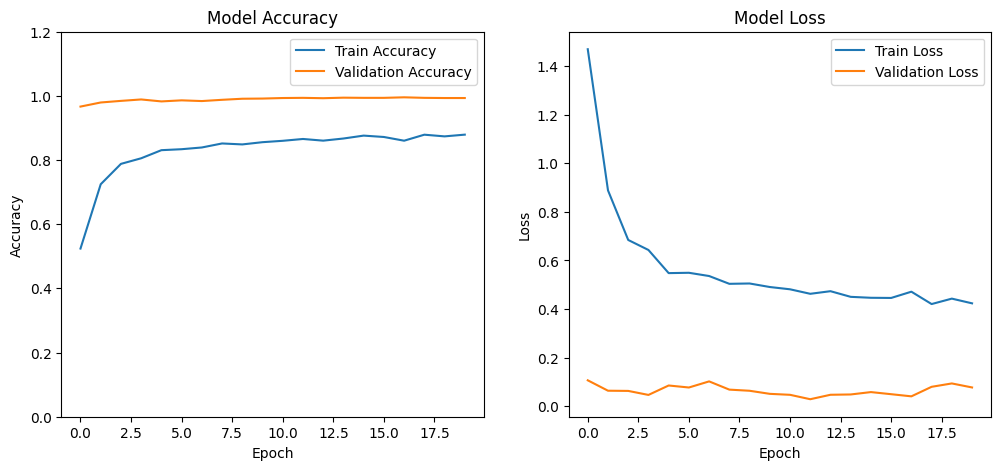



 Evaluate using validation data
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      1.00       200
   Gilt-Head Bream       0.99      0.99      0.99       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       1.00      0.99      0.99       200
     Red Sea Bream       0.99      0.99      0.99       200
          Sea Bass       1.00      0.98      0.99       200
            Shrimp       0.98      1.00      0.99       200
Striped Red Mullet       0.98      0.97      0.98       200
             Trout       1.00      1.00      1.00       200

          accuracy                           0.99      1800
         macro avg       0.99      0.99      0.99      1800
      weighted avg       0.99      0.99      0.99      1800



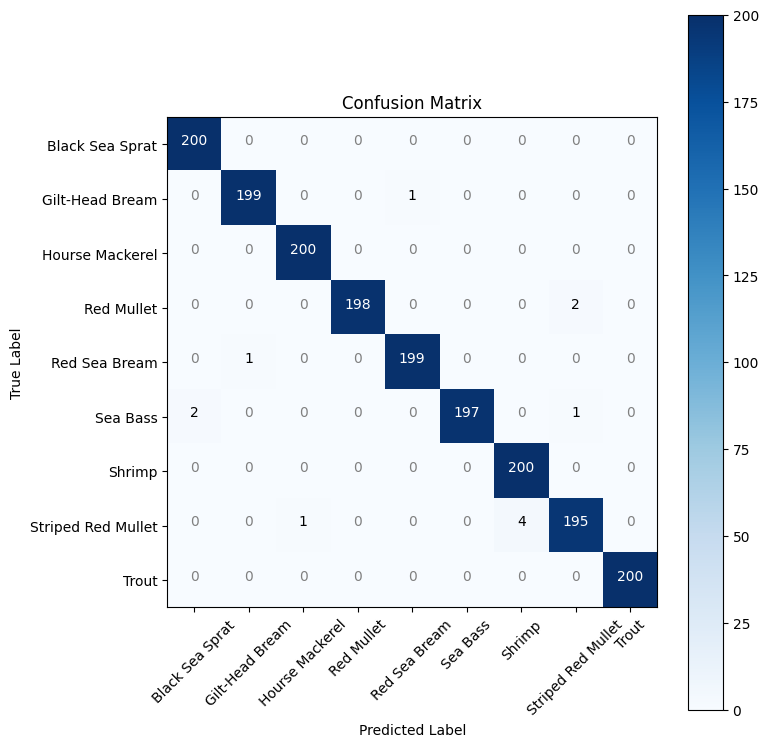



 Evaluate using test data
 24/450 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.98      0.99      0.99       100
   Gilt-Head Bream       1.00      0.99      0.99       100
   Hourse Mackerel       0.98      1.00      0.99       100
        Red Mullet       1.00      0.99      0.99       100
     Red Sea Bream       0.99      1.00      1.00       100
          Sea Bass       1.00      0.97      0.98       100
            Shrimp       1.00      1.00      1.00       100
Striped Red Mullet       0.98      0.99      0.99       100
             Trout       1.00      1.00      1.00       100

          accuracy                           0.99       900
         macro avg       0.99      0.99      0.99       900
      weighted avg       0.99      0.99      0.99       900



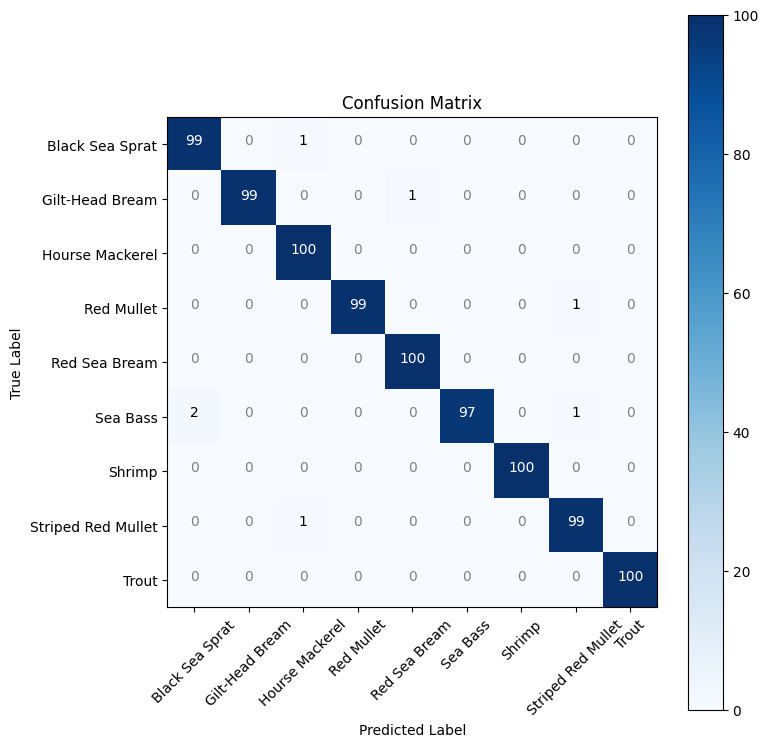

Model saved to Result/Model/Model_MobileNetV2/model.h5
Model layers information saved to Result/Model/Model_MobileNetV2/model_layers.json


Model summary saved to Result/Model/Model_MobileNetV2/model_summary.txt


In [38]:
# Direktori untuk model
output_dir_model_MobileNetV2 = os.path.join(output_root, "Model_MobileNetV2")
os.makedirs(output_dir_model_MobileNetV2, exist_ok=True)

# Melatih model
train_cnn_model(
    model_MobileNetV2,
    os.path.join("Dataset_R", "train"),
    os.path.join("Dataset_R", "val"),
    os.path.join("Dataset_R", "test"),
    epochs=20,
    batch_size=2,
    output_dir=output_dir_model_MobileNetV2
)

In [39]:
shutil.copytree(f"/content/{output_dir_model_MobileNetV2}", f"/content/drive/MyDrive/UAP_MACHINE LEARNING/Result/Model/{output_dir_model_MobileNetV2}", dirs_exist_ok=True)


'/content/drive/MyDrive/UAP_MACHINE LEARNING/Result/Model/Result/Model/Model_MobileNetV2'

In [40]:
!zip -r 'Result.zip' '/content/Result'

  adding: content/Result/ (stored 0%)
  adding: content/Result/Model/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/model_summary.txt (deflated 97%)
  adding: content/Result/Model/Model_MobileNetV2/model_layers.json (deflated 94%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Test/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Test/Confusion_Matrix.png (deflated 16%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Test/classification_report.txt (deflated 72%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Validation/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Validation/Confusion_Matrix.png (deflated 14%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Validation/classification_report.txt (deflated 72%)
  adding: content/Result/Model/